In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import os
import scipy as scp
from scipy.linalg import expm
from sympy.physics.quantum.sho1d import RaisingOp, LoweringOp
from sympy.physics.quantum import qapply, represent

import scienceplots

plt.style.use(['science', 'notebook', 'nature'])

In [2]:
# number of vectors taken from the computational basis
d_unit = 20
dir_res = 'results'


# Tools


In [3]:
def n_avg(beta) :
    '''
    Returns the average number of particles at a given inverse temperature

    Parameters
    ----------
    beta : array
        inverse temperature

    Return
    ------
    n_avg : array
        average number of particles at T=1/beta

    '''
    return 1/(np.exp(beta) - 1)

n_avg(0.5)

1.5414940825367982

In [4]:
def save_results(sols, folder, subfolder, i) :
    '''
    Save the results of the optimization in a subfolder of folder

    Parameters
    ----------
    sols : dic
        results of the optimization
    folder : str
        location where output is written
    subfolder : str
        name of the subfolder
    i : int
        index of optimization
    '''
    subfolder = f'{folder}/output_{i}'
    os.makedirs(subfolder, exist_ok=True)

    np.savetxt(f'{subfolder}/history.txt', sols['history'])
    np.savetxt(f'{subfolder}/loss_rho_best.txt', sols['fopt'])
    np.savetxt(f'{subfolder}/lagr_best.txt', sols['lagr_best'])
    np.savetxt(f'{subfolder}/inverse_temperature.txt', sols['inv_temp'])
    np.savetxt(f'{subfolder}/rho_best.txt', np.atleast_1d(sols['rho_best'].toarray()))
    lindbladian = lindblad(sols['rho_best'], H, a, at, beta).toarray()
    
    L_best = np.linalg.norm(lindbladian, 'nuc')
    np.savetxt(f'{subfolder}/lindblad_norm_best.txt', np.atleast_1d(L_best))
    
    I = scp.sparse.eye(len(lindbladian))
    S_prod = -np.trace((I + scp.linalg.logm(sols['rho_best'].toarray())) @ lindbladian) 
    np.savetxt(f'{subfolder}/S_prod_best.txt', np.atleast_1d(S_prod.real.item()))
        


def optimize(l, lagr_0, a, at, beta, dim_single_part, ansatz, exponent_ansatz, lindblad, folder, i, **args) :
    '''
    Minimize the loss l with respect to the lagrange multipliers, 
    and write all results in folder/output.data

    Parameters
    ----------
    l : function
        loss
    lagr_0 : array
        initial guess for the lagrange multipliers
    a : array
        annihilation operator
    at : array
        creation operator
    beta : array
        inverse temperature
    ansatz : function
        compute the ansatz for the density matrix given lagrand multipliers
    exponent_ansatz : function
        compute the exponent of the ansatz for the density matrix
    lindblad : function
        compute the lindblad operator
    folder : str
        location where output is written
    i : int
        index of optimization
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Note
    ----
    fmin[0]     # xopt 
    fmin[1]     # fopt
    fmin[2]     # nb iteration
    fmin[3]     # funcalls
    fmin[4]     # warnflag
    fmin[5]     # solution at each iterations
    '''
    sols = {}
    solution = fmin(lambda x: l(x, ansatz, exponent_ansatz, a, at, lindblad, beta, **args), lagr_0, retall=True, full_output=True)
    sols['inv_temp'] = np.array([beta])
    sols['history'] = np.array(solution[5])
    sols['lagr_best'] = solution[0]
    sols['rho_best'] = ansatz(sols['lagr_best'], a, at, **args)
    sols['fopt'] = np.array([solution[1]])

    save_results(sols, folder, f'output_{i}', i)

    return sols



In [5]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : csr_array
        matrix

    Return
    ------
    exp(M) : csr_array
    '''
    return scp.sparse.csr_array(expm(M.toarray()))
    

# Quantum Operators


In [6]:
def creation_annihilation(N) :
    '''
    Create $a$ and $a^\dag$ the single particle creation and annihilation operators
    in the (sparse) matrix form, in the computational basis {|n>}.

    Parameters
    ----------
    N : int
        number of excited states to use in the basis
    
    Return
    ------
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    '''
    a = LoweringOp('a')
    ad = RaisingOp('a')

    a = scp.sparse.coo_array(represent(a, ndim=N, format="scipy.sparse"))
    ad = scp.sparse.coo_array(represent(ad, ndim=N, format="scipy.sparse"))

    return a, ad

a, ad = creation_annihilation(d_unit)

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [7]:
# harc-core bosonic creation and annihilation operators
def get_cj(j, a, N) :
    I = scp.sparse.eye(a.shape[0])
    c = 1
    for i in range(N) :
        if i == j :
            c = scp.sparse.kron(c, a)
        else :
            c = scp.sparse.kron(c, I)
    return c


def get_cj_dagger(j, ad, N) :
    return get_cj(j, ad, N)


def get_cjs_list(a, N) :
    L = []
    for j in range(N) :
        L.append(get_cj(j, a, N))
    return L


def get_cjs_dagger_list(ad, N) :
    L = []
    for j in range(N) :
        L.append(get_cj_dagger(j, a, N))
    return L


N = 3
dim_unit = 2                        # to ensure a**2 = 0
a, at = creation_annihilation(dim_unit)

L = get_cjs_list(a, N)
for l in L :
    print(l.toarray())

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


# Hamiltonians


SHO: $ \hat H = \hat a^\dag \hat a $


In [8]:
def H_sho(a, at, **args) :
    '''
    Computes the matrix form of the Hamiltonian of the Simple Harmonic Oscillator
    in the computational basis: 
    $ H = a^\dag a $

    Parameters
    ----------
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : coo_array
        matrix form of Hamiltonian 
    '''
    extra_params = args 
    H = scp.sparse.coo_array(at @ a)
    return H

np.diagonal(H_sho(a, at).toarray())

array([0., 1.])

Drive: $ \hat H = \hat a^\dag \hat a + \epsilon \left( \hat a + \hat a^\dag \right) $


In [9]:
def H_drive(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    epsilon = args['epsilon']
    H = at @ a + epsilon * (a + at)
    return H

np.diagonal(H_drive(a, at, **{'epsilon': 0.2}).toarray())

array([0., 1.])

Kerr: $ \hat H = \hat a^\dag \hat a + \epsilon \, \hat a^\dag \hat a^\dag \hat a \hat a $


In [10]:
def H_kerr(a, at, **args) :
    '''
    Computes the matrix form of a Hamiltonian in the computational basis

    Parameters
    ----------
    a : array
        annihilation operator
    at : array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : array
        matrix form of Hamiltonian 
    '''
    epsilon = args['epsilon']
    H = at @ a + epsilon * (at @ at @ a @ a)
    return H

np.diagonal(H_kerr(a, at, **{'epsilon': 0.2}).toarray())

array([0., 1.])

In [11]:
def H_wouters(a, at, **args) :
    t = args['t']
    N = args['N']
    J = args['J']
    lambd = args['lambda']

    cjs, cjs_dagger = get_cjs_list(a, N), get_cjs_dagger_list(at, N) 

    H = scp.sparse.csr_matrix(cjs[0].shape)
    for j in range(N-1) :
        H -= t * (cjs_dagger[j+1] @ cjs[j] + cjs_dagger[j] @ cjs[j+1])
    for j in range(N) :
        H += J * np.cos(2 * np.pi * j / lambd) * cjs_dagger[j] @ cjs[j]
    return H

dim_unit = 2                        # to ensure a**2 = 0
params_H = {
    't': 1,
    'N': 4,
    'J': 12,
    'lambda': 5,
}
a, at = creation_annihilation(dim_unit)
H_wouters(a, at, **params_H)

<16x16 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

# Ansätze


SHO : $$ \hat \rho = \frac{e^{- \lambda \hat a^\dagger \hat a}}{\text{Tr}(e^{- \lambda \hat a^\dagger \hat a})}$$


In [12]:
def exponent_ansatz_sho(lagr, a, at, **args) :
    '''
    Exponent of the ansatz for the density matrix given some parameters
    Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat a^\dagger \hat a}}{\text{Tr}(e^{- \lambda \hat a^\dagger \hat a})}$

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
    
    Return
    ------
    exponent : cooarray

    Note
    ----
    Used to simplify the computation of entropy production
    '''
    return - lagr * at @ a

def ansatz_sho(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters
    Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat a^\dagger \hat a}}{\text{Tr}(e^{- \lambda \hat a^\dagger \hat a})}$

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr * at @ a)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

exponent_ansatz_sho(0.7, a, at), ansatz_sho(0.7, a, at)   

(<2x2 sparse array of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x2 sparse array of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>)

Kerr : $$ \hat \rho = \frac{e^{- \lambda_0 \hat a^\dag \hat a - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat a^\dag \hat a - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$$


In [13]:
def exponent_ansatz_kerr(lagr, a, at, **args) :
    '''
    Exponent of the ansatz for the density matrix given some parameters
    Ansatz :  $ \hat \rho = \frac{e^{- \lambda_0 \hat a^\dag \hat a - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat a^\dag \hat a - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
    
    Return
    ------
    exponent : cooarray

    Note
    ----
    Used to simplify the computation of entropy production
    '''
    return - lagr[0] * at @ a - lagr[1] * at @ at @ a @ a


def ansatz_kerr(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * at @ a - lagr[1] * at @ at @ a @ a)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

ansatz_kerr(np.array([0.7, 1]), a, at)


<2x2 sparse array of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

#### Ansatz : $ \hat \rho = \frac{e^{- \lambda_0 \hat a^\dagger \hat a - \lambda_1 \left( \hat a + \hat a^\dag \right) }}{\text{Tr}(e^{- \lambda_0 \hat a^\dagger \hat a - \lambda_1 \left( \hat a + \hat a^\dag \right) })}$


In [14]:
def exponent_ansatz_drive(lagr, a, at, **args) :
    '''
    Exponent of the ansatz for the density matrix given some parameters
    Ansatz :  $ \hat \rho = \frac{e^{- \lambda_0 \hat a^\dag \hat a - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a }}{\text{Tr}(e^{- \lambda_0 \hat a^\dag \hat a - \lambda_1 \hat a^\dag \hat a^\dag \hat a \hat a })}$

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
    
    Return
    ------
    exponent : cooarray

    Note
    ----
    Used to simplify the computation of entropy production
    '''
    return - lagr[0] * at @ a - lagr[1] * (a + at)


def ansatz_drive(lagr, a, at, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr[0] * at @ a - lagr[1] * (a + at))
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

ansatz_drive(np.array([0.7, 1]), a, at)


<2x2 sparse array of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

#### Ansatz Wouters : $ \hat \rho = \frac{e^{- \lambda*j \sum_j a_j^\dagger a_j - \sum*{i,j} V*{i,j} a_j^\dagger a_i^\dagger a_i a_j }}{\text{Tr}(e^{- \lambda_j \sum_j a_j^\dagger a_j - \sum*{i,j} V\_{i,j} a_j^\dagger a_i^\dagger a_i a_j})}$


$ - \lambda*j \sum_j a_j^\dagger a_j - \sum*{i,j} V\_{i,j} a_j^\dagger a_i^\dagger a_i a_j $


In [15]:
def exponent_ansatz_Wouters(lagr, a, at, **args) :
    N = args['N'] 

    lambdas = lagr[:N]
    V = np.zeros((N, N))

    if args['kerr'] == True :
        V_lagr = lagr[N:].copy()
        V_lagr.reshape(N, N)

    ansatz = np.zeros((2**N, 2**N))

    for j in range(N) :
        ansatz -= lambdas[j] * ajs_dagger_list[j] @ ajs_list[j] 

    if args['kerr'] == True :
        for i in range(N) :
            for j in range(N) :
                ansatz -= V_lagr[i, j] * ajs_dagger_list[j] @ ajs_dagger_list[i] @ ajs_list[i] @ ajs_list[j]

    return scp.sparse.csr_matrix(ansatz)


def ansatz_drive(lagr, a, at, **args) :
    
    exponent_ansatz = exponent_ansatz_Wouters(lagr, a, at, **args)
    
    U = exp_mat(exponent_ansatz)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

N = 4
ajs_list, ajs_dagger_list = get_cjs_list(a, N), get_cjs_dagger_list(at, N) 

guess_lambdas = [1 for i in range(N)]
guess_V = np.ones((len(guess_lambdas), len(guess_lambdas)))
guesses = np.array(guess_lambdas + guess_V.reshape(-1).tolist())
ansatz_drive(guesses, a, at, **{'N':N, 'kerr':False})


<16x16 sparse array of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

# Lindbladian


$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [18]:
def lindblad(M, H, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M given a Hamiltonian H

    Parameters
    ----------
    M : csr_array 
        density matrix
    H : coo_array
        Hamiltonian
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H @ M - M @ H)
    L1 = (n_avg(beta) + 1) * (a @ M @ at - 0.5 * (at @ a @ M + M @ at @ a))
    L2 = n_avg(beta) * (at @ M @ a - 0.5 * (a @ at @ M + M @ a @ at))
    return L0 + L1 + L2

rho = ansatz_sho(0.7, a, at, dim_single_part=d_unit)
H = ansatz_sho(0.7, a, at, dim_single_part=d_unit) 

lindblad(rho, H, a, at, 0.5)

<2x2 sparse array of type '<class 'numpy.complex128'>'
	with 2 stored elements in Compressed Sparse Row format>

$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] $


In [19]:
def lindblad_wouters(M, H, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M given a Hamiltonian H without any dissipator

    Parameters
    ----------
    M : csr_array 
        density matrix
    H : coo_array
        Hamiltonian

    Return
    ------
    L : float
        the lindbladian

    Notes
    -----
    Other parameters are not used. They are here to match the requirements of optimize() 
    '''
    L0 = - 1j * (H @ M - M @ H)
    return L0

a, ad = creation_annihilation(d_unit)
rho = ansatz_sho(0.7, a, ad, dim_single_part=d_unit)
H = ansatz_sho(0.7, a, ad, dim_single_part=d_unit) 

lindblad_wouters(rho, H, a, ad, 0.5)

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<20x20 sparse array of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

# Losses


In [20]:
def entropy_production(lagr, ansatz, exponent_ansatz, a, ad, lindblad, beta, **args) :
    '''
    Computes the entropy production of a density matrix given some parameters


    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        compute the ansatz for the density matrix given lagrange multipliers
    exponent_ansatz : function
        compute the exponent of the ansatz for the density matrix given lagrange multipliers
    a : coo_array
        annihilation operator
    ad : coo_array
        creation operator
    lindblad : function
        computes the lindbladian of a density matrix M given a Hamiltonian H
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    S_prod : float
        the entropy production
    '''
    ansats_M = ansatz(lagr, a, ad, dim_single_part=d_unit)
    exponent_ansatz_M = exponent_ansatz(lagr, a, ad, dim_single_part=d_unit)
    tot_dim = exponent_ansatz_M.shape[0]
    I = scp.sparse.eye(tot_dim)
    Z = scp.sparse.csr_matrix.trace(exp_mat(exponent_ansatz_M))

    lindbladian = lindblad(ansats_M, H, a, ad, beta, **args)
    # S_prod = -scp.sparse.csr_matrix.trace((I + exponent_ansatz_M - np.log(Z) * I) @ lindbladian) 
    S_prod = -np.trace((I + scp.linalg.logm(ansats_M.toarray())) @ lindbladian) 
    return np.abs(S_prod)

ans, exp_ans = exponent_ansatz_sho(0.7, a, ad), ansatz_sho(0.7, a, ad) 
lindbladian = lindblad(ans, exp_ans, a, ad, 0.5) 
entropy_production(0.7, ansatz_sho, exponent_ansatz_sho, a, ad, lindblad, 0.5)

0.38853560268142384

In [21]:
def lindblad_norm(lagr, ansatz, exponent_ansatz, a, at, lindblad, beta, **args) :
    '''
    Computes the (Nuclear) norm of the Lindbladian of an ansatz density matrix
    given the Lagrange multipliers

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        ansatz used in the variational procedure
    exponent_ansatz : function
        exponent of the ansatz used in the variational procedure. Useless here.
        Present because of the arguments needed in the optimization function
    a : array
        annihilation operator
    at : array
        creation operator
    lindblad : function
        computes the lindbladian of a density matrix given a Hamiltonian H
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    ||L rho || : float
        the Nuclear norm of the linbladian of the density matrix

    Note
    ----
    We use the Nuclear norm because it is not biased (see [1])

    References
    ----------
    [1] - Weimer, Variational principle for steady states of dissipative quantum many-body systems, 2015
    '''
    return np.linalg.norm(lindblad(ansatz(lagr, a, at, **args), H, a, at, beta, **args).toarray(), 'nuc')

ans, exp_ans = exponent_ansatz_sho(0.7, a, ad), ansatz_sho(0.7, a, ad) 
lindbladian = lindblad(ans, exp_ans, a, ad, 0.5) 
lindblad_norm(0.7, ansatz_sho, exponent_ansatz_sho, a, ad, lindblad, 0.5)

0.28133401160956967

# Convention


- cases in [1, 9]: lindblad norm optimisation
- cases in [10, 90]: entropy production minimization


# Case 1


- H: SHO
- Ansatz: SHO (Gibbs)
- loss: lindblad norm


In [162]:
case = 1
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

##### set-up


In [163]:
dim_unit = 20
lambda_0 = np.array([1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

H = H_sho(a, at)                 # Hamiltonian
ansatz = ansatz_sho
exponent_ansatz = exponent_ansatz_sho
loss = lindblad_norm

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [164]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
[1.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
[2.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 38
[3.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 40
[4.]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 44
[5.]


##### Plot


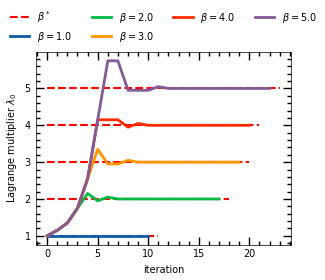

In [167]:
lagr_to_plot = [0]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions, lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


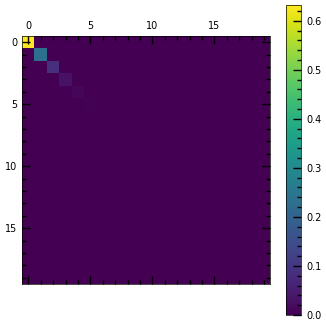

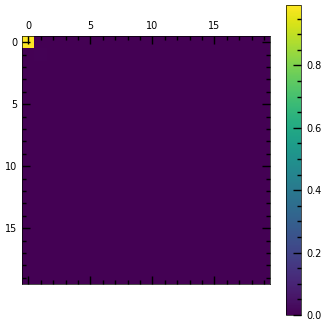

In [168]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 10


- H: SHO
- Ansatz: SHO (Gibbs)
- loss: entropy production


In [169]:
case = 10
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

##### set-up


In [170]:
dim_unit = 20
lambda_0 = np.array([1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

H = H_sho(a, at)                 # Hamiltonian
ansatz = ansatz_sho
exponent_ansatz = exponent_ansatz_sho
loss = entropy_production

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [171]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
[1.]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
[2.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 38
[3.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 40
[4.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 42
[5.]


##### Plot


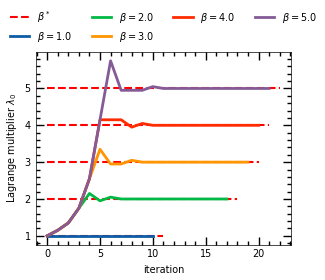

In [172]:
lagr_to_plot = [0]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions, lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


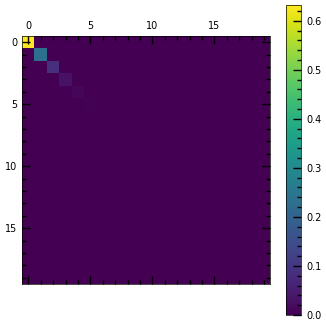

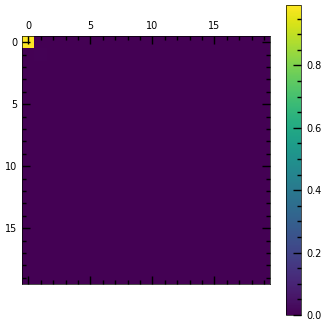

In [173]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 2


- H: SHO
- Ansatz: kerr
- loss: lindblad norm


In [174]:
case = 2
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [175]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

H = H_sho(a, at)                 # Hamiltonian
ansatz = ansatz_kerr
exponent_ansatz = exponent_ansatz_kerr
loss = lindblad_norm

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [176]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 50
         Function evaluations: 95
[ 9.99977205e-01 -8.91331112e-06]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 36
         Function evaluations: 70
[ 1.99999676e+00 -2.68023790e-05]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 48
         Function evaluations: 93
[2.99999464e+00 3.75486997e-06]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 65
         Function evaluations: 125
[4.00000277e+00 3.04580627e-05]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 68
         Function evaluations: 131
[5.00000074e+00 3.59124886e-05]


##### Plot


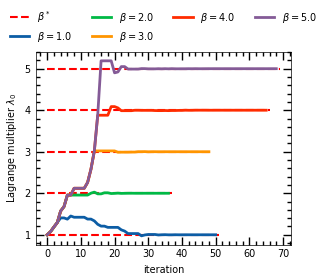

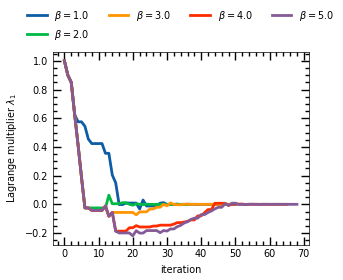

In [177]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


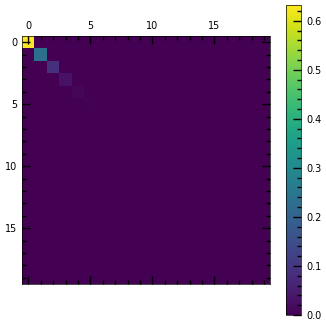

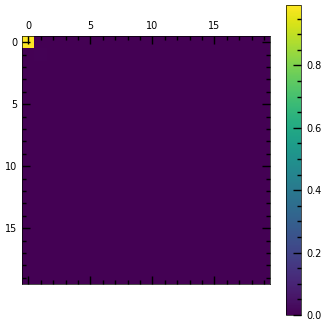

In [178]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 20


- H: SHO
- Ansatz: kerr
- loss: entropy production


In [179]:
case = 20
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [180]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

H = H_sho(a, at)                 # Hamiltonian
ansatz = ansatz_kerr
exponent_ansatz = exponent_ansatz_kerr
loss = entropy_production

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [181]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 39
         Function evaluations: 77
[ 1.08781706 -0.03869699]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 60
[0.9978983  1.02617531]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 90
[1.96967481 5.37615771]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 77
         Function evaluations: 146
[ 3.55752061 15.58374406]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 80
         Function evaluations: 148
[ 4.86283358 20.69480798]


##### Plot


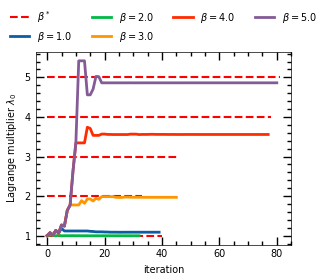

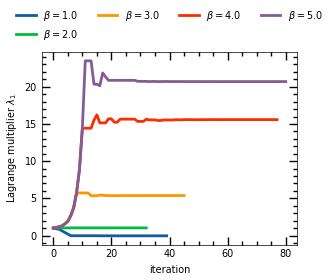

In [182]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


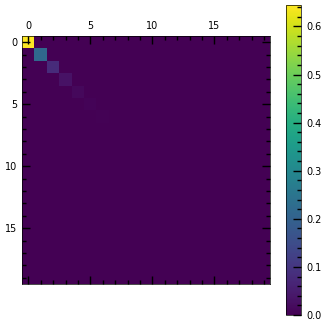

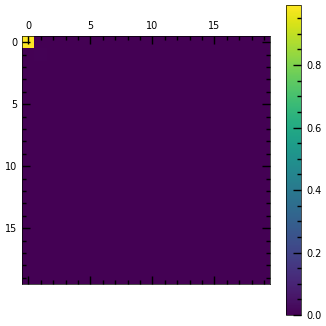

In [183]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 3


- H: drive
- Ansatz: kerr
- loss: lindblad norm


In [184]:
case = 3
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [185]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    'epsilon' : 0.1
}

H = H_drive(a, at, **params_H)                 # Hamiltonian
ansatz = ansatz_kerr
exponent_ansatz = exponent_ansatz_kerr
loss = lindblad_norm

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [186]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.112314
         Iterations: 51
         Function evaluations: 97
[ 0.98555557 -0.00133646]
Optimization terminated successfully.
         Current function value: 0.155806
         Iterations: 34
         Function evaluations: 66
[1.92625385 0.00277416]
Optimization terminated successfully.
         Current function value: 0.179347
         Iterations: 48
         Function evaluations: 91
[2.74021215 0.12154612]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.189661
         Iterations: 50
         Function evaluations: 98
[3.32929818 0.32040951]
Optimization terminated successfully.
         Current function value: 0.193739
         Iterations: 57
         Function evaluations: 108
[3.6756681  0.62498797]


##### Plot


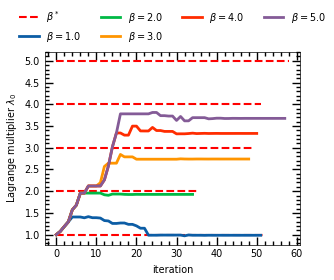

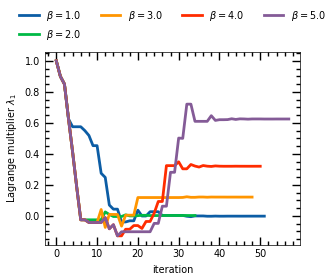

In [187]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


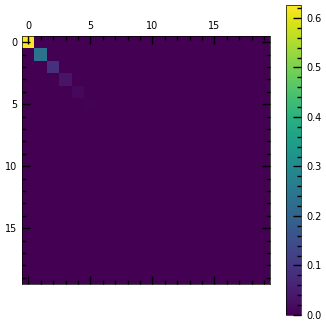

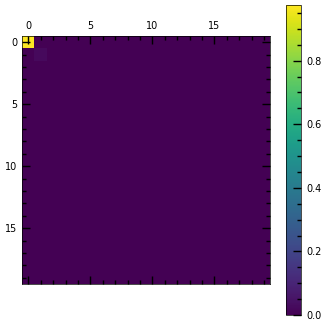

In [188]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 30


- H: drive
- Ansatz: kerr
- loss: entropy production


In [191]:
case = 30
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [192]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    'epsilon' : 0.1
}

H = H_drive(a, at, **params_H)                 # Hamiltonian
ansatz = ansatz_kerr
exponent_ansatz = exponent_ansatz_kerr
loss = entropy_production

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [193]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 39
         Function evaluations: 77
[ 1.08781706 -0.03869699]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 60
[0.9978983  1.02617531]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 90
[1.96967481 5.37615771]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 77
         Function evaluations: 146
[ 3.55752061 15.58374406]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 80
         Function evaluations: 148
[ 4.86283358 20.69480798]


##### Plot


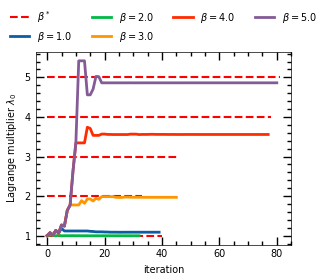

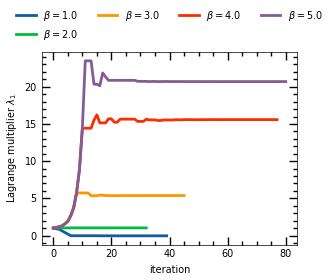

In [194]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


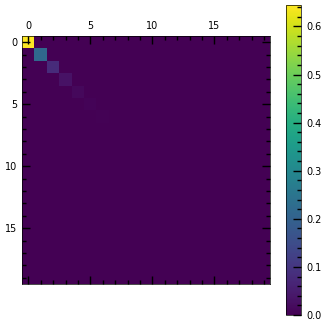

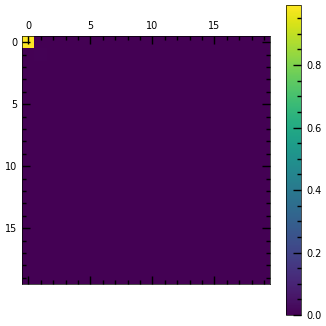

In [195]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 4


- H: Kerr
- Ansatz: kerr
- loss: lindblad norm


In [196]:
case = 4
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [197]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    'epsilon' : 0.1
}

H = H_kerr(a, at, **params_H)                 # Hamiltonian
ansatz = ansatz_kerr
exponent_ansatz = exponent_ansatz_kerr
loss = lindblad_norm

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [198]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 50
         Function evaluations: 95
[ 9.99977205e-01 -8.91331112e-06]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 36
         Function evaluations: 70
[ 1.99999676e+00 -2.68023790e-05]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 48
         Function evaluations: 93
[2.99999464e+00 3.75486997e-06]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 65
         Function evaluations: 125
[4.00000277e+00 3.04580627e-05]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 68
         Function evaluations: 131
[5.00000074e+00 3.59124886e-05]


##### Plot


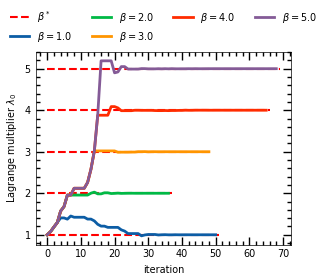

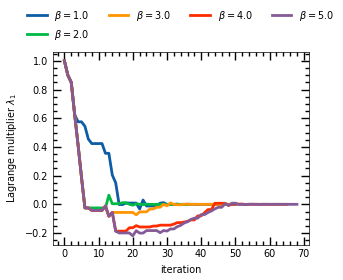

In [199]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


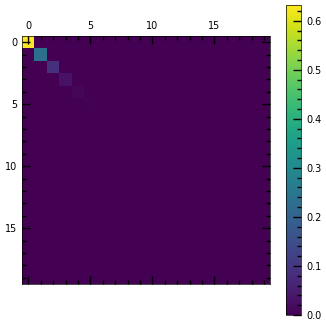

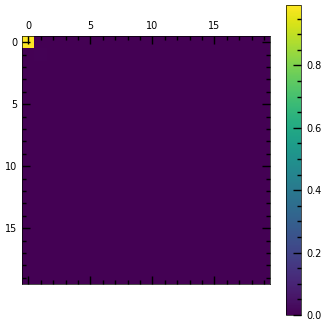

In [200]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 40


- H: Kerr
- Ansatz: kerr
- loss: entropy production


In [201]:
case = 40
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [202]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    'epsilon' : 0.1
}

H = H_kerr(a, at, **params_H)                 # Hamiltonian
ansatz = ansatz_kerr
exponent_ansatz = exponent_ansatz_kerr
loss = entropy_production

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [203]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 39
         Function evaluations: 77
[ 1.08781706 -0.03869699]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 60
[0.9978983  1.02617531]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 90
[1.96967481 5.37615771]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 77
         Function evaluations: 146
[ 3.55752061 15.58374406]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 80
         Function evaluations: 148
[ 4.86283358 20.69480798]


##### Plot


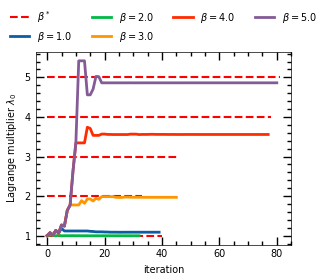

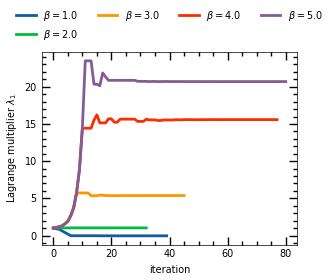

In [205]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


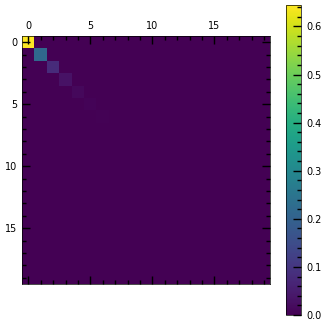

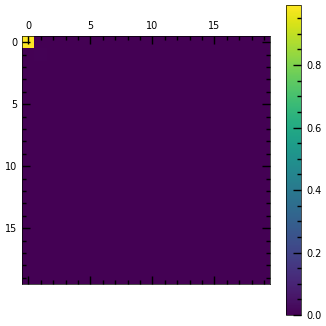

In [206]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 5


- H: Drive
- Ansatz: Drive
- loss: lindblad norm


In [207]:
case = 5
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [208]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    'epsilon' : 0.1
}

H = H_drive(a, at, **params_H)                 # Hamiltonian
ansatz = ansatz_drive
exponent_ansatz = exponent_ansatz_drive
loss = lindblad_norm

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [209]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.050388
         Iterations: 40
         Function evaluations: 79
[0.99702195 0.07976294]
Optimization terminated successfully.
         Current function value: 0.070135
         Iterations: 43
         Function evaluations: 84
[1.98520653 0.15880616]
Optimization terminated successfully.
         Current function value: 0.081127
         Iterations: 59
         Function evaluations: 114
[2.95207494 0.23616523]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.086044
         Iterations: 66
         Function evaluations: 126
[3.85052739 0.3080387 ]
Optimization terminated successfully.
         Current function value: 0.087972
         Iterations: 68
         Function evaluations: 128
[4.59365677 0.36749231]


##### Plot


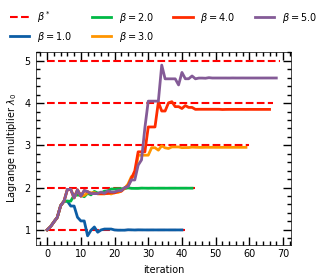

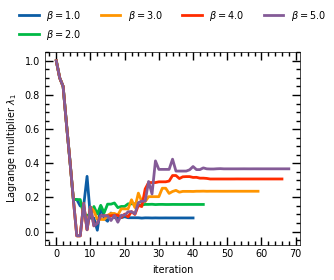

In [210]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


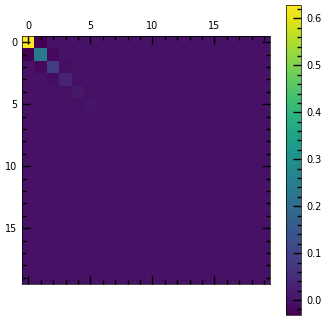

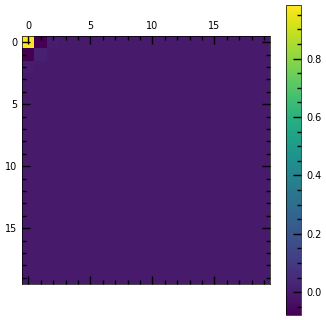

In [211]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case 50


- H: Drive
- Ansatz: Drive
- loss: entropy production


In [212]:
case = 50
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [213]:
dim_unit = 20
lambda_0 = np.array([1, 1])
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    'epsilon' : 0.1
}

H = H_drive(a, at, **params_H)                 # Hamiltonian
ansatz = ansatz_drive
exponent_ansatz = exponent_ansatz_drive
loss = entropy_production

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [214]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 96
[0.99983922 1.05875787]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 75
         Function evaluations: 141
[2.         1.20072364]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 64
         Function evaluations: 118
[3.         1.41422118]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 125
[4.         1.64604438]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 109
[5.         1.75331946]


##### Plot


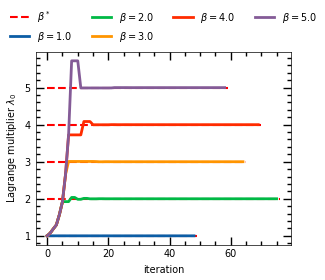

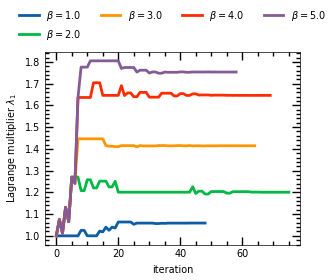

In [215]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


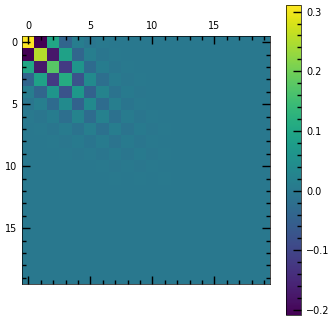

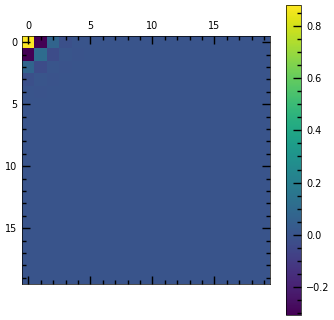

In [216]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Case wouter


- H: Wouter
- Ansatz: Drive
- loss: entropy production


In [101]:
case = 'wouters'
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

In [99]:
dim_unit = 2                        # to ensure a**2 = 0
a, at = creation_annihilation(dim_unit)
betas = np.linspace(1, 5, 5)        # true inverse temperature

params_H = {
    't': 1,
    'N': 4,
    'J': 12,
    'lambda': 5,
}

params_Wouters = {
    'N': params_H['N'],
    'kerr': False
}
lambda_0 = np.ones((params_H['N'] + params_H['N']*params_H['N']))

ajs_list, ajs_dagger_list = get_cjs_list(a, params_H['N']), get_cjs_dagger_list(at, params_H['N']) 

H = H_wouters(a, at, **params_H)                 # Hamiltonian
ansatz = lambda x, y, z: ansatz_drive(x, y, z, **params_Wouters)
exponent_ansatz = exponent_ansatz_drive
loss = lindblad_norm
lindblad_to_use = lindblad_wouters

##### compute


In [102]:
for i,beta in enumerate(betas) :
    opt = optimize(loss, lambda_0, a, at, beta, dim_unit, ansatz, exponent_ansatz, lindblad_to_use, folder, i)
    print(opt['lagr_best'])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 219


ValueError: dimension mismatch

##### Plot


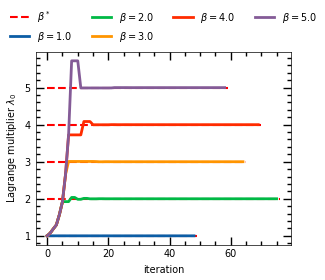

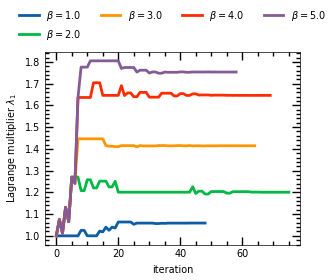

In [232]:
lagr_to_plot = [0, 1]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for j, lagr in enumerate(lagr_to_plot) :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions[lagr]), color='r', ls='--', lw=1.5, label=r'$\beta^*$' if i==0 else "")
        plt.plot(explored_solutions[lagr], lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.27))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


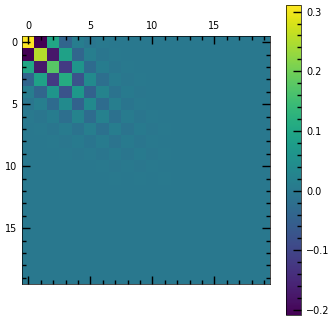

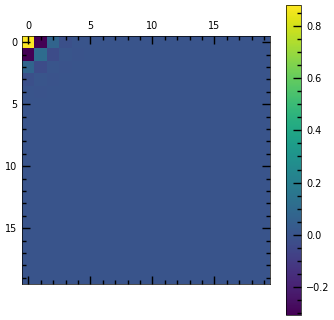

In [233]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()

# Compare cases


## Loss: lindblad norm


##### compute


In [218]:
cases_to_compare = np.array([1, 2, 3, 4, 5])
is_to_plot = np.arange(3)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        filename = f'results/case_{c}/output_{i}/lindblad_norm_best.txt'
        loss_best = np.loadtxt(filename)
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_lindblad_norm.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


Text(0.5, 1.0, 'Loss: Lindblad norm')

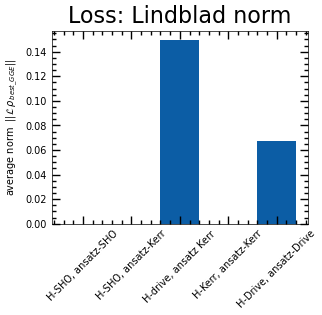

In [219]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_lindblad_norm.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['H-SHO, ansatz-SHO', 
     'H-SHO, ansatz-Kerr', 
     'H-drive, ansatz Kerr', 
     'H-Kerr, ansatz-Kerr', 
     'H-Drive, ansatz-Drive'
    ]

plt.bar(X, losses)
plt.ylabel(r'average norm  $||  \mathcal{L} \, \rho_{\,best\_GGE}||$')
plt.xticks(range(len(cases_to_compare)), X, rotation=45)
plt.title('Loss: Lindblad norm')
# plt.savefig('figs/comp_avg_loss.pdf')


## Loss: entropy production


##### compute


In [221]:
cases_to_compare = np.array([10, 20, 30, 40, 50])
is_to_plot = np.arange(3)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        filename = f'results/case_{c}/output_{i}/lindblad_norm_best.txt'
        loss_best = np.loadtxt(filename)
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_lindblad_norm.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


Text(0.5, 1.0, 'Loss: Entropy production')

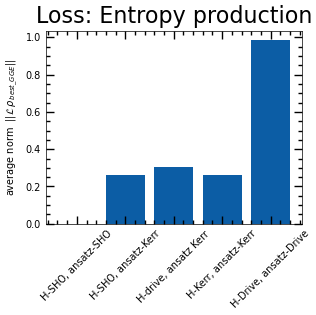

In [222]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_lindblad_norm.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['H-SHO, ansatz-SHO', 
     'H-SHO, ansatz-Kerr', 
     'H-drive, ansatz Kerr', 
     'H-Kerr, ansatz-Kerr', 
     'H-Drive, ansatz-Drive'
    ]

plt.bar(X, losses)
plt.ylabel(r'average norm  $||  \mathcal{L} \, \rho_{\,best\_GGE}||$')
plt.xticks(range(len(cases_to_compare)), X, rotation=45)
plt.title('Loss: Entropy production')
# plt.savefig('figs/comp_avg_loss.pdf')


## Loss: comparison of losses


##### compute


In [223]:
cases_to_compare = np.array([1, 2, 3, 4, 5, 10, 20, 30, 40, 50])
is_to_plot = np.arange(3)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        filename = f'results/case_{c}/output_{i}/lindblad_norm_best.txt'
        loss_best = np.loadtxt(filename)
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_lindblad_norm.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


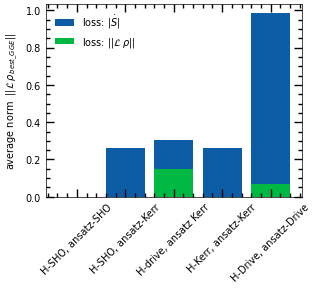

In [224]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_lindblad_norm.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['H-SHO, ansatz-SHO', 
     'H-SHO, ansatz-Kerr', 
     'H-drive, ansatz Kerr', 
     'H-Kerr, ansatz-Kerr', 
     'H-Drive, ansatz-Drive'
    ]

n = len(losses) // 2
plt.bar(X, losses[n:], label=r'loss: $|\dot S$|')
plt.bar(X, losses[:n], label=r'loss: $||  \mathcal{L} \, \rho||$')
plt.ylabel(r'average norm  $||  \mathcal{L} \, \rho_{\,best\_GGE}||$')
plt.xticks(range(len(cases_to_compare) // 2), X, rotation=45)
plt.legend()
plt.savefig('figs/comp_avg_loss.pdf')


##### compute


In [4]:
cases_to_compare = np.array([1, 2, 3, 4, 5, 10, 20, 30, 40, 50])
is_to_plot = np.arange(3)

losses = []

for c in cases_to_compare :
    avg = 0
    for i in is_to_plot :
        filename = f'results/case_{c}/output_{i}/S_prod_best.txt'
        loss_best = np.loadtxt(filename)
        avg += loss_best
    avg /= len(is_to_plot)
    losses.append(avg)

np.savetxt('results/comp_cases/comp_avg_S_prod.txt', np.vstack((cases_to_compare, np.array(losses))).T)


##### plot


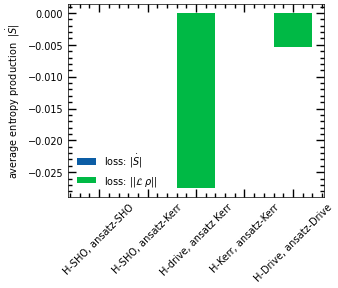

In [7]:
cases_to_compare, losses = np.loadtxt('results/comp_cases/comp_avg_S_prod.txt', unpack=True)
cases_to_compare = cases_to_compare.astype(int)

X = ['H-SHO, ansatz-SHO', 
     'H-SHO, ansatz-Kerr', 
     'H-drive, ansatz Kerr', 
     'H-Kerr, ansatz-Kerr', 
     'H-Drive, ansatz-Drive'
    ]

n = len(losses) // 2
plt.bar(X, losses[n:], label=r'loss: $|\dot S|$')
plt.bar(X, losses[:n], label=r'loss: $||  \mathcal{L} \, \rho||$')
plt.ylabel(r'average entropy production  $|\dot S|$')
plt.xticks(range(len(cases_to_compare) // 2), X, rotation=45)
plt.legend()
plt.savefig('figs/comp_avg_S_prod.pdf')
